In [21]:
# import packages
import pandas as pd
import numpy as np
import re
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# nltk.download('stopwords')

from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from tools import *

%matplotlib inline

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
# read dataset
review_data= pd.read_csv("Reviews.csv")

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# view the dataset
review_data.head(5)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# cleanse text
review_data['Text'] = review_data['Text'].apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# what 
max_review_data_sentence_length  = review_data['Num_words_text'].max()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# filter data for short reviews
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)

print('No of Short reviews: ', len(df_short_reviews))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


No of Short reviews:  373288


In [7]:
# remove stopwords from the text (e.g. the, and, it)
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# convert text column to a list
text_list=df_sampled['Text'].tolist()

# review
print(text_list[1])

amazon mess earn kind star cant submit review looking worst product ever amazon sells tastes like plastic


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# lemmatise the sentences
tokenized_reviews = lemmatization(text_list)

# review
print(tokenized_reviews[1])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['mess', 'kind', 'star', 'review', 'bad', 'product', 'taste', 'plastic']


In [10]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# review the topics which have been created
lda_model.print_topics()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.112*"coffee" + 0.037*"flavor" + 0.028*"good" + 0.021*"strong" + 0.018*"taste" + 0.014*"blend" + 0.014*"coconut" + 0.014*"bean" + 0.013*"vanilla" + 0.013*"great"'),
 (1,
  '0.044*"cereal" + 0.041*"free" + 0.039*"rice" + 0.030*"bread" + 0.027*"gluten" + 0.022*"wheat" + 0.021*"corn" + 0.021*"grain" + 0.016*"whole" + 0.016*"organic"'),
 (2,
  '0.049*"store" + 0.037*"price" + 0.035*"product" + 0.030*"great" + 0.026*"good" + 0.023*"order" + 0.022*"local" + 0.017*"time" + 0.016*"grocery" + 0.013*"shipping"'),
 (3,
  '0.059*"chip" + 0.036*"snack" + 0.029*"good" + 0.025*"great" + 0.025*"flavor" + 0.020*"taste" + 0.017*"tooth" + 0.017*"green" + 0.015*"healthy" + 0.013*"salad"'),
 (4,
  '0.035*"protein" + 0.024*"high" + 0.016*"noodle" + 0.016*"beef" + 0.014*"fiber" + 0.012*"veggie" + 0.011*"vitamin" + 0.010*"product" + 0.010*"sodium" + 0.010*"daily"'),
 (5,
  '0.051*"chocolate" + 0.048*"flavor" + 0.036*"good" + 0.028*"salt" + 0.025*"sauce" + 0.021*"taste" + 0.019*"bar" + 0.017*"great" +

In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.133719  0.120441       1        1  21.186894
2     -0.098847  0.158974       2        1  14.602996
0     -0.174038 -0.027290       3        1  13.920131
6     -0.141402 -0.120638       4        1  12.339126
5     -0.128713 -0.089409       5        1   9.598313
7      0.010731  0.141834       6        1   7.162117
3     -0.126440 -0.133727       7        1   6.335604
4      0.252365  0.023287       8        1   5.810562
9      0.257805  0.207161       9        1   4.783425
1      0.282258 -0.280633      10        1   4.260832, topic_info=          Term          Freq         Total Category  logprob  loglift
99      coffee  31511.000000  31511.000000  Default  30.0000  30.0000
153       food  22338.000000  22338.000000  Default  29.0000  29.0000
152     flavor  32076.000000  32076.000000  Default  28.0000  28.0000
431      store  14350.000000  14350.000000  Default  27.0000  27.0000
129  chocolate   9945.000000   9945.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
86     chicken   1063.359909   4537.911037  Topic10  -4.3900   1.7047
884       find    662.100276   1213.134420  Topic10  -4.8637   2.5502
623    crunchy    699.632390   2258.166490  Topic10  -4.8086   1.9840
225    healthy    764.397725   8308.643863  Topic10  -4.7201   0.7697
29     texture    699.820853   3835.988111  Topic10  -4.8083   1.4543

[532 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4281      5  0.997870    absolute
2284      6  0.996596    addicted
1896     10  0.998642   addictive
4494      7  0.998978       adult
3478      8  0.999091  affordable
...     ...       ...         ...
456       2  0.227154        year
456       3  0.077078        year
456       6  0.179168        year
240      10  0.997803       yeast
2938      9  0.999107       young

[732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 1, 7, 6, 8, 4, 5, 10, 2])

In [18]:
# a measure of how good the model is. lower the better
print('Perplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  -8.960667157811852


In [22]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.4061912789114982


In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


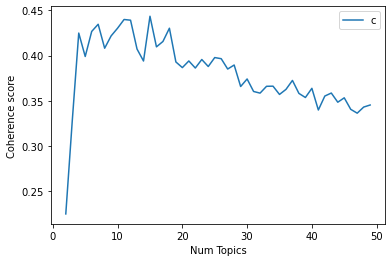

In [25]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [26]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2249
Num Topics = 3  has Coherence Value of 0.3279
Num Topics = 4  has Coherence Value of 0.4248
Num Topics = 5  has Coherence Value of 0.399
Num Topics = 6  has Coherence Value of 0.4267
Num Topics = 7  has Coherence Value of 0.4346
Num Topics = 8  has Coherence Value of 0.4081
Num Topics = 9  has Coherence Value of 0.4217
Num Topics = 10  has Coherence Value of 0.4303
Num Topics = 11  has Coherence Value of 0.4399
Num Topics = 12  has Coherence Value of 0.4391
Num Topics = 13  has Coherence Value of 0.4072
Num Topics = 14  has Coherence Value of 0.394
Num Topics = 15  has Coherence Value of 0.4435
Num Topics = 16  has Coherence Value of 0.4096
Num Topics = 17  has Coherence Value of 0.4155
Num Topics = 18  has Coherence Value of 0.4302
Num Topics = 19  has Coherence Value of 0.3929
Num Topics = 20  has Coherence Value of 0.3867
Num Topics = 21  has Coherence Value of 0.394
Num Topics = 22  has Coherence Value of 0.3862
Num Topics = 23  has Coh

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.049*"flavor" + 0.022*"sweet" + 0.021*"good" + 0.020*"taste" + 0.015*"great" + 0.014*"drink" + 0.012*"little" + 0.012*"energy" + 0.012*"product" + 0.012*"love"'),
 (1,
  '0.083*"food" + 0.022*"dog" + 0.020*"treat" + 0.017*"butter" + 0.017*"good" + 0.016*"peanut" + 0.016*"cat" + 0.014*"chicken" + 0.012*"meal" + 0.012*"year"'),
 (2,
  '0.026*"good" + 0.026*"sugar" + 0.019*"snack" + 0.019*"healthy" + 0.018*"product" + 0.018*"great" + 0.018*"free" + 0.015*"cereal" + 0.014*"taste" + 0.013*"sweet"'),
 (3,
  '0.049*"product" + 0.018*"great" + 0.016*"good" + 0.015*"time" + 0.015*"price" + 0.014*"order" + 0.010*"shipping" + 0.010*"bar" + 0.010*"bottle" + 0.009*"year"'),
 (4,
  '0.047*"flavor" + 0.035*"taste" + 0.027*"good" + 0.021*"green" + 0.020*"milk" + 0.020*"drink" + 0.018*"vanilla" + 0.017*"water" + 0.015*"strong" + 0.015*"tea"'),
 (5,
  '0.146*"coffee" + 0.026*"good" + 0.016*"bean" + 0.016*"strong" + 0.016*"kcup" + 0.015*"great" + 0.013*"flavor" + 0.013*"blend" + 0.013*"roast" + 

In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, doc_term_matrix, dictionary)
vis

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.198676  0.041928       1        1  15.713864
2      0.063404 -0.168477       2        1  12.720546
1     -0.149070 -0.118130       3        1  12.079248
7     -0.212702  0.060796       4        1  11.771587
0      0.106688 -0.047664       5        1  11.272322
5      0.030445  0.244931       6        1  10.153860
4      0.210262  0.095941       7        1   9.618892
8      0.075118 -0.106439       8        1   8.786082
6      0.074531 -0.002886       9        1   7.883598, topic_info=          Term          Freq         Total Category  logprob  loglift
99      coffee  31893.000000  31893.000000  Default  30.0000  30.0000
153       food  21115.000000  21115.000000  Default  29.0000  29.0000
129  chocolate  10005.000000  10005.000000  Default  28.0000  28.0000
431      store  13030.000000  13030.000000  Default  27.0000  27.0000
152     flavor  32043.000000  32043.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
380       love   1034.827992  13968.273963   Topic9  -5.0325  -0.0622
808    perfect    854.979359   6455.815517   Topic9  -5.2234   0.5187
146       well    813.974755   9667.813041   Topic9  -5.2725   0.0658
620      brand    813.424807   9741.466332   Topic9  -5.2732   0.0575
522       many    719.878951   7811.098803   Topic9  -5.3954   0.1562

[675 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2830      1  0.981219     active
2830      4  0.002562     active
2830      9  0.015372     active
1896      2  0.996517  addictive
1896      4  0.001805  addictive
...     ...       ...        ...
456       6  0.075007       year
456       7  0.017350       year
456       8  0.012991       year
456       9  0.061571       year
3524      2  0.998558     yogurt

[1782 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 8, 1, 6, 5, 9, 7])

In [31]:
pyLDAvis.save_html(vis, 'output.html')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
